In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# **Explore the data**

In [3]:
print(train.keys())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


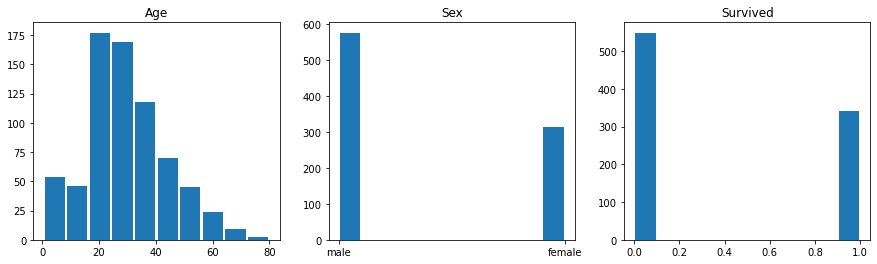

In [4]:
#raw data
fig, ax = plt.subplots(1,3)
ax[0].hist(train.Age,rwidth=0.9)
ax[0].set_title('Age')
ax[1].hist(train.Sex,rwidth=0.9)
ax[1].set_title('Sex')
ax[2].hist(train.Survived,rwidth=0.9)
ax[2].set_title('Survived')
fig.set_figwidth(15)
plt.show()

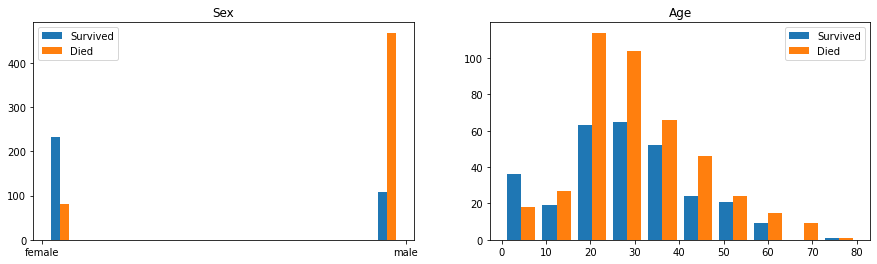

In [5]:
fig, ax = plt.subplots(1,2)
#how likely are you to survive based on gender?
ax[0].hist([train.Sex[train.Survived==1], train.Sex[train.Survived==0]],rwidth=0.5)
ax[0].legend(labels=['Survived','Died'])
ax[0].set_title('Sex')
#how likely are you to survive based on age?
ax[1].hist([train.Age[train.Survived==1], train.Age[train.Survived==0]])
ax[1].legend(labels=['Survived','Died'])
ax[1].set_title('Age')
fig.set_figwidth(15)
plt.show()

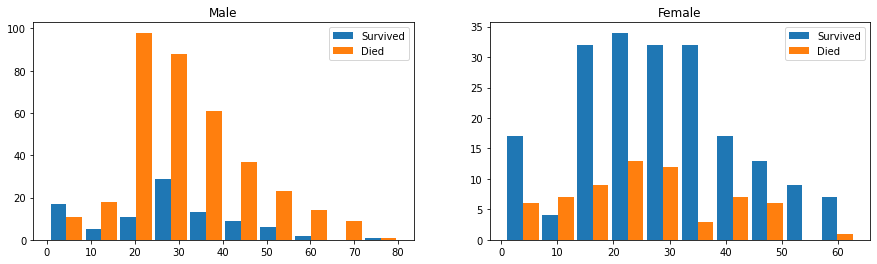

In [6]:
#Combining these two...
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist([train.Age[(train.Survived==1) & (train.Sex=='male')],
          train.Age[(train.Survived==0) & (train.Sex=='male')]],rwidth=0.9)
ax1.legend(labels=['Survived','Died'])
ax1.set_title('Male')
ax2.hist([train.Age[(train.Survived==1) & (train.Sex=='female')],
          train.Age[(train.Survived==0) & (train.Sex=='female')]],rwidth=0.9)
ax2.legend(labels=['Survived','Died'])
ax2.set_title('Female')
fig.set_figwidth(15)
plt.show()


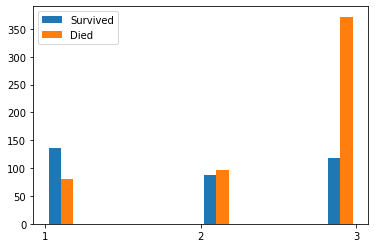

In [7]:
#Deaths based on ticket class...
plt.hist([train.Pclass[train.Survived==1],train.Pclass[train.Survived==0]])
plt.xticks([1,2,3])
plt.legend(['Survived','Died'])
plt.show()

# **Data cleaning, is there missing data?**

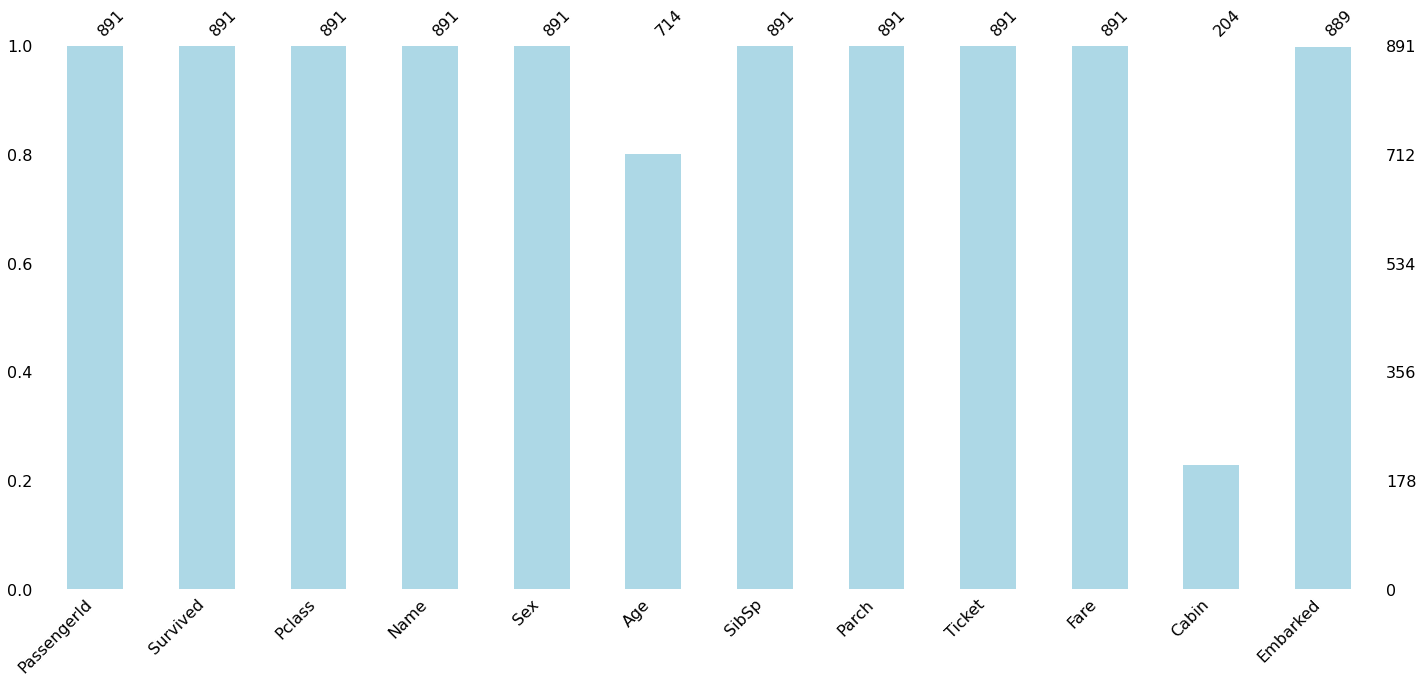

In [8]:
import missingno as msno
#missing data in train.csv
msno.bar(train,color='lightblue')
plt.show()

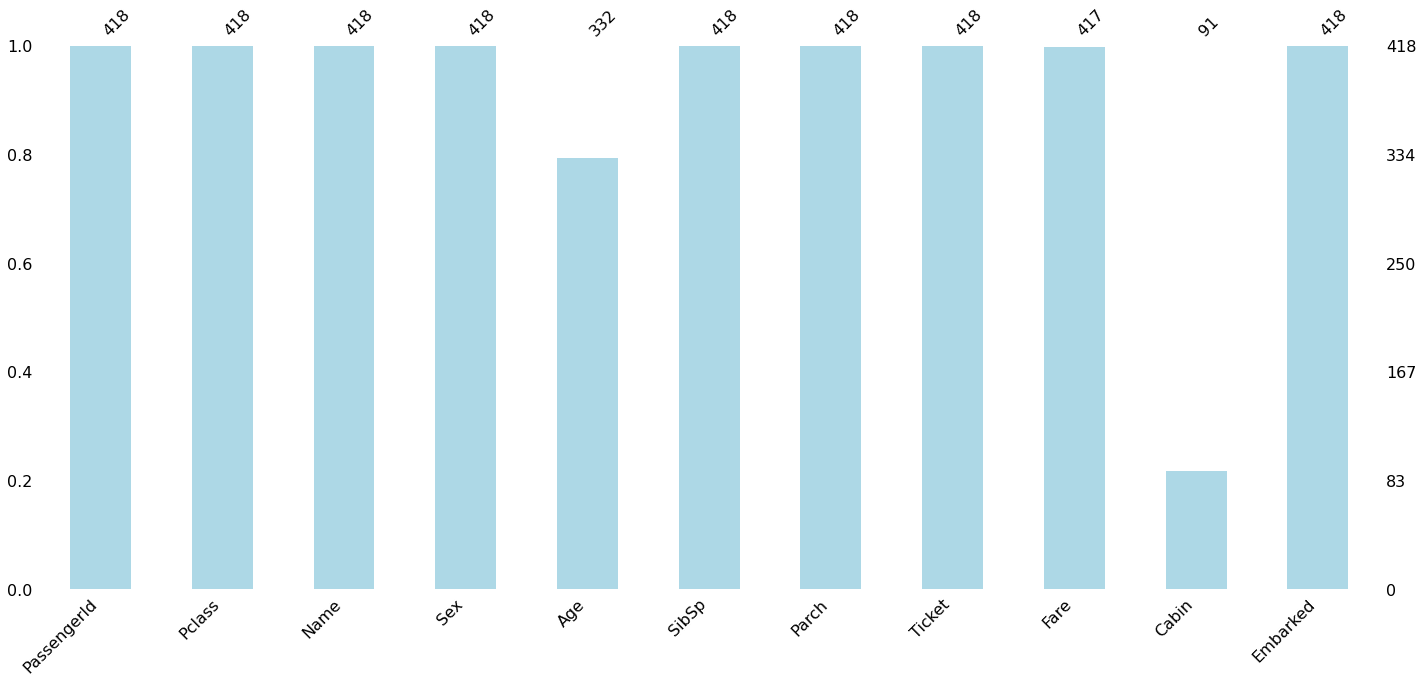

In [9]:
#missing data in test.csv
msno.bar(test,color='lightblue')
plt.show()

A lot of missing cabin and age data

* I will replace missing 'Age' data with the median age.
* I will probably not use 'Cabin' data in the model - replace nans with 'unknown' for now.
* I will replace missing 'Embarked' data with the most common value (i.e. the mode).
* I will replace missing 'Fare' data with the median.

In [10]:
def clean_data(data):
    #Replace missing ages with median age
    data.Age.fillna(data.Age.median(),inplace=True)

    #fill Cabin=Nan with 'unknown'
    data.Cabin.fillna('unknown',inplace=True)

    #replace embarked with mode
    data.Embarked.fillna(data.Embarked.mode()[0],inplace=True)
    
    #replace missing fare with median fare
    data.Fare.fillna(data.Fare.median(),inplace=True)
    
    return data

train = clean_data(train)
test = clean_data(test)

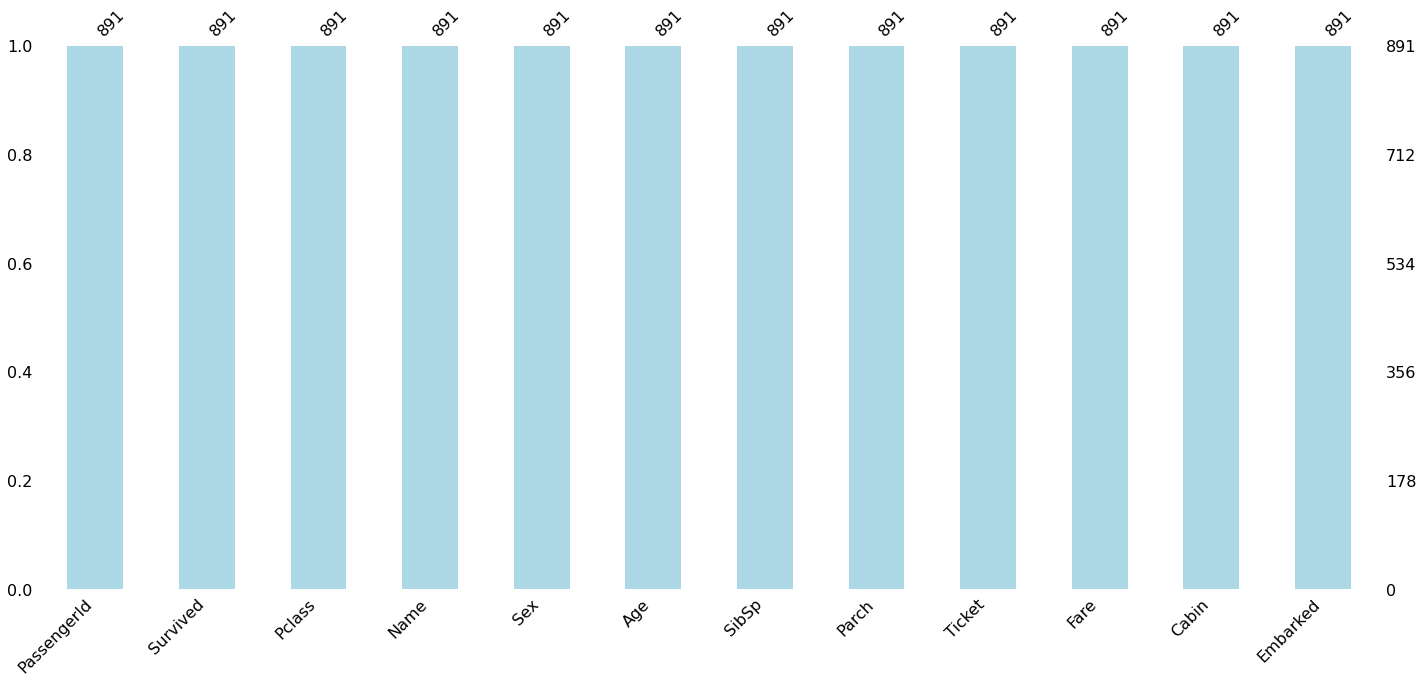

In [11]:
#train data
msno.bar(train,color='lightblue')
plt.show()

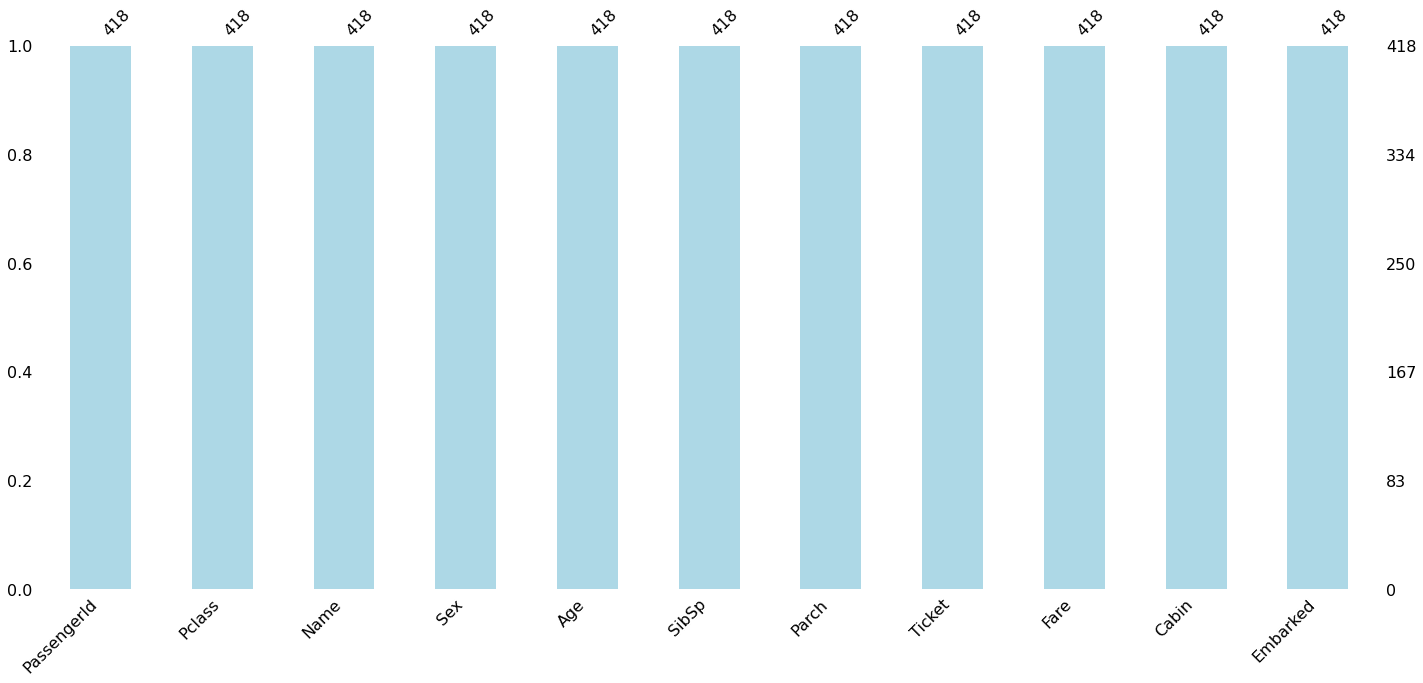

In [12]:
#test data
msno.bar(test,color='lightblue')
plt.show()

**All columns are now filled in both the training and test data...**

In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,unknown,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,unknown,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,unknown,S


In [14]:
#feature engineering
def reformat_data(data):
    #make gender numerical
    data.Sex = data.Sex.replace('male',0)
    data.Sex = data.Sex.replace('female',1)
    
    #make embarked numerical
    data.Embarked = data.Embarked.map({'S':0,'Q':1,'C':2,'U':3})
    
    #create family_size and alone column
    data['FamilySize'] = data.SibSp + data.Parch + 1
    data['Alone'] = 1
    data.Alone[data.FamilySize>1] = 0
    
    #create title column, Mr, Mrs etc...
    titles = [name.split(' ')[1] for name in data.Name]
    data['Title'] = titles
    data.Title = data.Title.map({'Mr.':1,'Miss.':2,'Mrs.':3,'Master.':4})
    data.Title.fillna(5, inplace=True)

    return data
    
train = reformat_data(train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [15]:
train.Title.value_counts()

1.0    502
2.0    179
3.0    121
5.0     49
4.0     40
Name: Title, dtype: int64

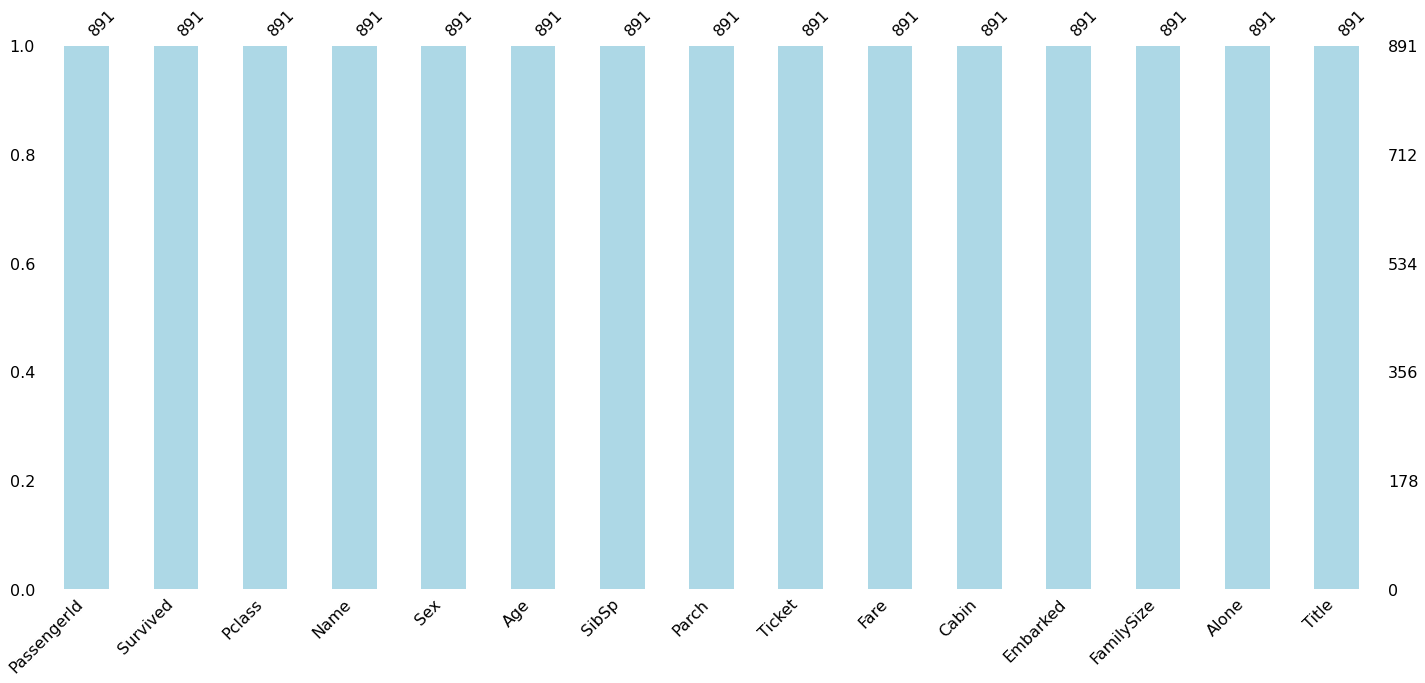

In [16]:
#final check 
msno.bar(train,color='lightblue')
plt.show()

In [17]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,unknown,0,2,0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,2,2,0,3.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,unknown,0,1,1,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0,3.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,unknown,0,1,1,1.0


# **use tensorflow randomforest**

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#features I want to use in my model
features = ['Pclass','Sex','Age','FamilySize','Alone','Fare','Embarked','Title']

train_df, test_df = train_test_split(train, test_size=0.25)
X_train = train_df[features]
Y_train = train_df['Survived']
X_test = test_df[features]
Y_test = test_df['Survived']

In [19]:
#train the model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, Y_train)
preds = rf.predict(X_test)
print('n_estimators: %i' %100)
print('train_score: %.2f ' %(rf.score(X_train, Y_train)*100))
print('test_score: %.2f ' %(rf.score(X_test, Y_test)*100))
print('')

n_estimators: 100
train_score: 98.65 
test_score: 80.27 



# **predict for test.csv**

In [20]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
test = clean_data(test)
test = reformat_data(test)
preds = rf.predict(test[features])
test['Survived'] = preds
print('test.csv predictions')
print(preds)

test.csv predictions
[0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0
 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0
 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0
 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1
 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [21]:
submission = test[['PassengerId','Survived']]
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [22]:
submission.to_csv('submission.csv',index=False)